## Description:

Calculate and test whether the variances of genotypes differ, i.e. what is the strength of the microbiome selection?



# Setting variables

# Init

In [1]:

%load_ext rpy2.ipython

In [2]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)
library(vegan)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: iterators

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from

# Loading rarified physeq object

In [3]:
%%R
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3_r')
physeq.Full = readRDS(F)
sd = sample_data(physeq.Full)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 49 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


## Calculate pairwise weighted Unifrac distances between samples

In [4]:
%%R
registerDoParallel(cores=28)
wunif.dist = distance(physeq.Full, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

## NMDS of w-Unifrac

Run 0 stress 0.1405103 
Run 1 stress 0.1541911 
Run 2 stress 0.1585737 
Run 3 stress 0.1433469 
Run 4 stress 0.1428386 
Run 5 stress 0.1512077 
Run 6 stress 0.1480856 
Run 7 stress 0.1421071 
Run 8 stress 0.1541862 
Run 9 stress 0.1767984 
Run 10 stress 0.1656861 
Run 11 stress 0.1569762 
Run 12 stress 0.1555973 
Run 13 stress 0.1549952 
Run 14 stress 0.1551584 
Run 15 stress 0.1582278 
Run 16 stress 0.1738023 
Run 17 stress 0.1534967 
Run 18 stress 0.2038889 
Run 19 stress 0.2028264 
Run 20 stress 0.1531357 


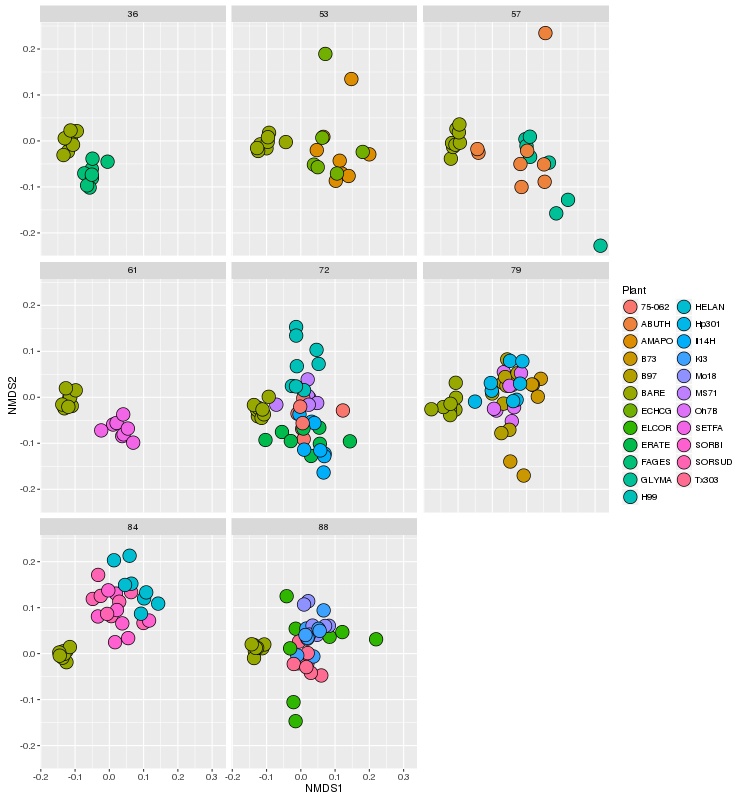

In [5]:
%%R -w 750 -h 800

nmds = ordinate(physeq.Full, 
                method = "NMDS", 
                distance = wunif.dist)

p = plot_ordination(physeq.Full, nmds, justDF = TRUE)

## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), size = 6, pch=21) +
        facet_wrap(~ DAP) +
        scale_size(range=c(2,8))

p1


# Explore variance of treatments


Mean distances:
                 Average
within groups  0.2152266
between groups 0.2690581
overall        0.2364820

Summary statistics:
                         Statistic
MRPP A weights n        0.15737374
MRPP A weights n-1      0.15649715
MRPP A weights n(n-1)   0.08988187
Classification strength 0.06979210
NULL
       BARE Rhizosphere 
  0.1218797   0.2277299 


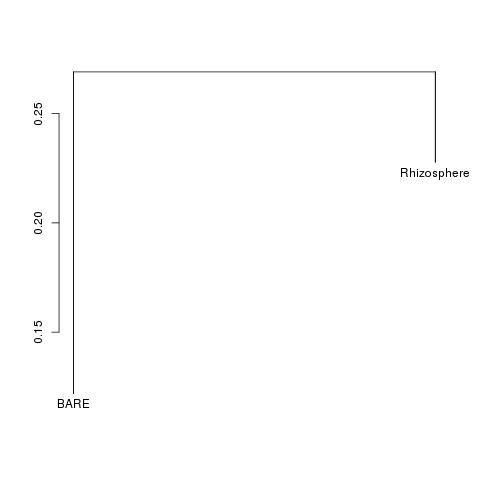

In [9]:
%%R
#meandist function returns average within and between group distances
sd = sample_data(physeq.Full)
MD = meandist(wunif.dist, sd$Planted)
summary(MD) %>% print
plot(MD, kind = "histogram") %>% print

diag(MD) #Diagonal of matrix returns the within group average distances

In [10]:
%%R
Spread = data.frame(diag(MD))
Spread$Sample = row.names(Spread)
Spread_ordered = arrange(Spread, diag.MD.)
Spread_ordered

   diag.MD.      Sample
1 0.1218797        BARE
2 0.2277299 Rhizosphere


## Hypothesis testing dispersion

In [12]:
%%R
m = betadisper(wunif.dist, sd$Planted, type = c("median","centroid"), bias.adjust = FALSE)
permutest(m, pairwise = TRUE)


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df  Sum Sq  Mean Sq      F N.Perm Pr(>F)    
Groups      1 0.25914 0.259137 184.73    999  0.001 ***
Residuals 236 0.33106 0.001403                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Pairwise comparisons:
(Observed p-value below diagonal, permuted p-value above diagonal)
                  BARE Rhizosphere
BARE                         0.001
Rhizosphere 1.8314e-31            
